In [447]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import preprocessing

In [448]:
tit_df=pd.read_csv('C:\\Users\\sunny\\Downloads\\train.csv')

In [449]:
tit_df=tit_df.drop(['Name','Ticket','Cabin'],axis=1)
tit_df

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0              1         0       3    male  22.0      1      0   7.2500   
1              2         1       1  female  38.0      1      0  71.2833   
2              3         1       3  female  26.0      0      0   7.9250   
3              4         1       1  female  35.0      1      0  53.1000   
4              5         0       3    male  35.0      0      0   8.0500   
..           ...       ...     ...     ...   ...    ...    ...      ...   
886          887         0       2    male  27.0      0      0  13.0000   
887          888         1       1  female  19.0      0      0  30.0000   
888          889         0       3  female   NaN      1      2  23.4500   
889          890         1       1    male  26.0      0      0  30.0000   
890          891         0       3    male  32.0      0      0   7.7500   

    Embarked  
0          S  
1          C  
2          S  
3          S  
4          S  
..       ...  
886        S  
887        S  
888        S  
889        C  
890        Q  

[891 rows x 9 columns]

In [450]:
#EDA for some columns
#Count the null values
tit_df['Embarked'].isna().sum()

#Get the distinct values
tit_df['Embarked'].nunique()
tit_df['Embarked'].unique()

#Filter the null records only
tit_df[tit_df['Embarked'].isnull()]

#replace the na with the mode of the column
tit_df['Embarked'].fillna(str(list(tit_df.Embarked.mode())[0]),inplace=True)

In [451]:
le = preprocessing.LabelEncoder()
tit_df['Embarked_encoded']=le.fit_transform(tit_df['Embarked'])
tit_df['Sex_Encoded']=le.fit_transform(tit_df['Sex'])

#After EDA and encoding for 2 columns
print(tit_df)

     PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0              1         0       3    male  22.0      1      0   7.2500   
1              2         1       1  female  38.0      1      0  71.2833   
2              3         1       3  female  26.0      0      0   7.9250   
3              4         1       1  female  35.0      1      0  53.1000   
4              5         0       3    male  35.0      0      0   8.0500   
..           ...       ...     ...     ...   ...    ...    ...      ...   
886          887         0       2    male  27.0      0      0  13.0000   
887          888         1       1  female  19.0      0      0  30.0000   
888          889         0       3  female   NaN      1      2  23.4500   
889          890         1       1    male  26.0      0      0  30.0000   
890          891         0       3    male  32.0      0      0   7.7500   

    Embarked  Embarked_encoded  Sex_Encoded  
0          S                 2            1  
1      

In [452]:
def fill_age(tit_df):
    #Now using KNN for missing Age values
    #create a dataframe for null values
    tit_df_age_missing=tit_df[tit_df['Age'].isnull()]
    #create a dataframe for not null values
    tit_df_age_no_missing=tit_df[tit_df['Age'].notna()]
    
    from sklearn.neighbors import KNeighborsRegressor
    neigh = KNeighborsRegressor(n_neighbors=3)
    neigh.fit(tit_df_age_no_missing[['Pclass','SibSp','Parch','Sex_Encoded']],tit_df_age_no_missing['Age'])
    
    tit_df_age_missing['Age']=neigh.predict(tit_df_age_missing[['Pclass','SibSp','Parch','Sex_Encoded']])
    
    #Clean data after pre-processing

    tit_df_clean=pd.concat([tit_df_age_no_missing,tit_df_age_missing])
    
    return  tit_df_clean
    
    

In [453]:
tit_df_clean=fill_age(tit_df)
tit_df_clean=tit_df_clean[['Survived','Sex_Encoded','Pclass','Age','SibSp','Parch','Embarked_encoded','Fare','Sex','Embarked','PassengerId']]

<ipython-input-452-18b11a25578b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tit_df_age_missing['Age']=neigh.predict(tit_df_age_missing[['Pclass','SibSp','Parch','Sex_Encoded']])


In [454]:
from sklearn import tree
from sklearn.model_selection import train_test_split
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',ccp_alpha=0.002533890399684855)
x_train,x_test,y_train,y_test=train_test_split(tit_df_clean.iloc[:,1:2],
                                               tit_df_clean.iloc[:,0:1],
                                               random_state=0)
clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)

In [455]:
#Training Score
clf.score(x_train,y_train)
#Test Score
clf.score(x_test,y_test)

0.7668161434977578

In [456]:
#clf.fit(tit_df_clean.iloc[:,1:8],tit_df_clean.iloc[:,0:1])

In [457]:
#Post Pruning
def Pruning_Param(clf,x_train,y_train,x_test,y_test):
    clf = tree.DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(x_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    fig, ax = plt.subplots()
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha for training set")

    clfs = []
    for ccp_alpha in ccp_alphas:
        if ccp_alpha<=0:
            ccp_alpha=0
        clf = tree.DecisionTreeClassifier( ccp_alpha=ccp_alpha)
        clf.fit(x_train, y_train)
        clfs.append(clf)
    print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))
    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
    ax[0].set_xlabel("alpha")
    ax[0].set_ylabel("number of nodes")
    ax[0].set_title("Number of nodes vs alpha")
    ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("depth of tree")
    ax[1].set_title("Depth vs alpha")
    fig.tight_layout()

    train_scores = [clf.score(x_train, y_train) for clf in clfs]
    test_scores = [clf.score(x_test, y_test) for clf in clfs]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
    ax.legend()
    plt.show()
    
    ccp_alpha_df=pd.DataFrame(np.transpose([np.array(test_scores),np.array(clfs)]))
    final_ccp_alpha_val=ccp_alpha_df[ccp_alpha_df[0]==ccp_alpha_df[0].max()][1]
    print('CCP_VALUE that increases the test accuracy is: ',final_ccp_alpha_val)
    #print(ccp_alpha_df.to_csv('C:\\Users\\sunny\\Documents\\KCL - Study\\kaggle\\Titanic\\Pruning.csv'))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.14291331451027584


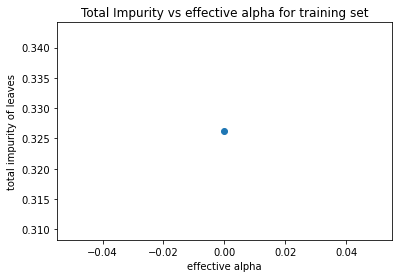

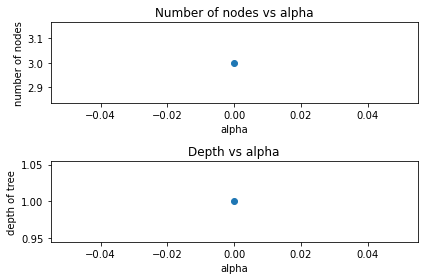

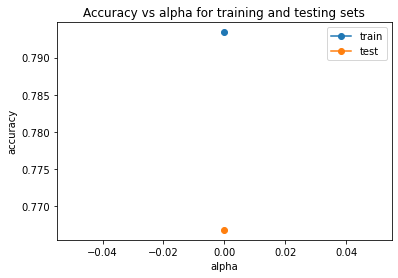

CCP_VALUE that increases the test accuracy is:  0    DecisionTreeClassifier(ccp_alpha=0)
Name: 1, dtype: object


In [458]:
Pruning_Param(clf,x_train,y_train,x_test,y_test)

In [459]:
#Submission Score

tit_df_test=pd.read_csv('C:\\Users\\sunny\\Downloads\\test.csv')
tit_df_test=tit_df_test.drop(['Name','Ticket','Cabin'],axis=1)
tit_df_test

PassengerId  Pclass     Sex   Age  SibSp  Parch      Fare Embarked
0            892       3    male  34.5      0      0    7.8292        Q
1            893       3  female  47.0      1      0    7.0000        S
2            894       2    male  62.0      0      0    9.6875        Q
3            895       3    male  27.0      0      0    8.6625        S
4            896       3  female  22.0      1      1   12.2875        S
..           ...     ...     ...   ...    ...    ...       ...      ...
413         1305       3    male   NaN      0      0    8.0500        S
414         1306       1  female  39.0      0      0  108.9000        C
415         1307       3    male  38.5      0      0    7.2500        S
416         1308       3    male   NaN      0      0    8.0500        S
417         1309       3    male   NaN      1      1   22.3583        C

[418 rows x 8 columns]

In [460]:

#replace the na with the mode of the column
tit_df_test['Embarked'].fillna(str(list(tit_df.Embarked.mode())[0]),inplace=True)

#replace the values na for Fare
tit_df_test['Fare'].fillna(8.05,inplace=True)

#decoding the value
le = preprocessing.LabelEncoder()
tit_df_test['Embarked_encoded']=le.fit_transform(tit_df_test['Embarked'])
tit_df_test['Sex_Encoded']=le.fit_transform(tit_df_test['Sex'])

#After EDA and encoding for 2 columns
print(tit_df_test)

     PassengerId  Pclass     Sex   Age  SibSp  Parch      Fare Embarked  \
0            892       3    male  34.5      0      0    7.8292        Q   
1            893       3  female  47.0      1      0    7.0000        S   
2            894       2    male  62.0      0      0    9.6875        Q   
3            895       3    male  27.0      0      0    8.6625        S   
4            896       3  female  22.0      1      1   12.2875        S   
..           ...     ...     ...   ...    ...    ...       ...      ...   
413         1305       3    male   NaN      0      0    8.0500        S   
414         1306       1  female  39.0      0      0  108.9000        C   
415         1307       3    male  38.5      0      0    7.2500        S   
416         1308       3    male   NaN      0      0    8.0500        S   
417         1309       3    male   NaN      1      1   22.3583        C   

     Embarked_encoded  Sex_Encoded  
0                   1            1  
1                   2    

In [461]:

#tit_df_test_age_missing=tit_df_test[tit_df_test['Age'].isnull()]
#create a dataframe for not null values
#tit_df_test_age_no_missing=tit_df_test[tit_df_test['Age'].notna()]

#from sklearn.neighbors import KNeighborsRegressor
#neigh = KNeighborsRegressor(n_neighbors=3)
#neigh.fit(tit_df_test_age_no_missing[['Pclass','SibSp','Parch','Fare','Embarked_encoded','Sex_Encoded']],tit_df_test_age_no_missing['Age'])
   
#tit_df_test_age_missing['Age']=neigh.predict(tit_df_test_age_missing[['Pclass','SibSp','Parch','Fare','Embarked_encoded','Sex_Encoded']])
    
#Clean data after pre-processing

#tit_df_test_clean=pd.concat([tit_df_test_age_missing,tit_df_test_age_missing])

In [463]:
tit_df_test_clean=fill_age(tit_df_test)
tit_df_test_clean=tit_df_test_clean[['Sex_Encoded','Pclass','Age','SibSp','Parch','Embarked_encoded','Fare','Sex','Embarked','PassengerId']]

<ipython-input-452-18b11a25578b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tit_df_age_missing['Age']=neigh.predict(tit_df_age_missing[['Pclass','SibSp','Parch','Sex_Encoded']])


In [465]:
tit_df_test_clean['Survived_Predicted'] = clf.predict(tit_df_test_clean.iloc[:,0:1])

In [466]:
tit_df_test_clean[['PassengerId','Survived_Predicted']].to_csv('C:\\Users\\sunny\\Documents\\KCL - Study\\kaggle\\Titanic\\Titanic_Submit.csv', index=False)